In [1]:
import torch
from torch import nn, optim, tensor
from torch.utils.data import DataLoader, Dataset
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, Vectors
import pandas as pd
import time
import numpy as np
import torch.nn.functional as TF
import matplotlib.pyplot as plt
import copy
import json
import random

## Load English & Chinese pretrained embedding from Tecent AI Lab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load pretrained model from Tencent
from gensim.models import KeyedVectors
# 100-dim en file
wv_from_text_en = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/LING111 autoencoder/tencent-ailab-embedding-en-d100-v0.1.0-s", binary=False)

# 100-dim zh file
wv_from_text_zh = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/LING111 autoencoder/tencent-ailab-embedding-zh-d100-v0.2.0-s.txt", binary=False)

In [4]:
# Define Chinese inputs for the model

# vocab_zh contains all the Chinese words in the dataset
vocab_zh      = wv_from_text_zh.index_to_key
vocab_size_zh = len(vocab_zh)
print("The first 10 words in the vocabulary are:", vocab_zh[:10])

# word_to_index is the map between Chinese words and its indeces {'的'：3}
word_to_index_zh = wv_from_text_zh.key_to_index
print("The index for the Chinese word '的' is:", word_to_index_zh['的'])

The first 10 words in the vocabulary are: ['</s>', '，', ',', '的', '。', '、', '了', '：', '“', '”']
The index for the Chinese word '的' is: 3


In [5]:
# Define English inputs for the model

# vocab_en contains all the English words in the dataset
vocab_en      = wv_from_text_en.index_to_key
vocab_size_en = len(vocab_en)
print("The first 10 words in the vocabulary are:", vocab_en[:10])

# word_to_index is the map between English words and its indeces {'yes'：3}
word_to_index_en = wv_from_text_en.key_to_index
print("The index for the English word 'cannot' is:", word_to_index_en["cannot"])

The first 10 words in the vocabulary are: ['%2c', '.', '%22', 'and', 'of', '%3a', 'a', 'in', '/', '%29']
The index for the English word 'cannot' is: 1202


## Load Golden Set

In [6]:
# Load the golden set
with open("/content/drive/MyDrive/LING111 autoencoder/full_golden_set.json", encoding="utf-8-sig") as in_file:
  # returns JSON object as a dictionary
    golden_set = json.load(in_file)

# Closing file
in_file.close()

word = "universal"
print("Chinese translation for {} is {}".format(word, golden_set[word][0]))

en_vocab = golden_set.keys()

Chinese translation for universal is 普遍


In [7]:
# en_vocab_list is list of unique English words in golden set
gold_en_list = list(golden_set.keys())

# length of English vocabulary
gold_en_size = len(gold_en_list)
print("There are", gold_en_size, "unique English words in our golden set")

There are 8063 unique English words in our golden set


## Data Preprocessing

In [8]:
torch.manual_seed(4)
np.random.seed(4)
random.seed(4)

In [9]:
# Define the training & testing data to pass for the custom dataset
# train_data is in the form of a dictionary that contains
# corresponding pair of English word (data) and Chinese
# translation (label)
# Last 15% of the dataset is testing data

train_data = {}
test_data  = {}
en_list_train = []
zh_list_train = []
en_list_test = []
zh_list_test = []
en_list = []
zh_list = []
en_index_train = []
zh_index_train = []
en_index_test = []
zh_index_test = []

# Shuffle the data before splitting it into train & test samples
random.shuffle(gold_en_list)

# Make

# Make copies of english words that have more than 1 Chinese translation
for en in gold_en_list:
    # en_list.append(en)
    # zhs = []
    for zh in golden_set[en]:
      en_list.append(en)
      zh_list.append(zh)
    #     zhs.append(zh)
    # zh_list.append(zhs)

# Last 15% of data is allocated as testing samples
cutoff = int(len(en_list) * 0.75)
en_list_train = en_list[:cutoff]
zh_list_train = zh_list[:cutoff]
en_list_test  = en_list[cutoff:]
zh_list_test  = zh_list[cutoff:]
print("There are", len(en_list_train), "training data and", len(en_list_test), "testing data")

# The real training data are the words that exist in the Tecent AI dataset

en_index_train = [(i, word_to_index_en[i]) for i, j in zip(en_list_train, zh_list_train) if i in word_to_index_en and j in word_to_index_zh]



zh_index_train = [(i, word_to_index_zh[i]) for i, j in zip(zh_list_train, en_list_train) if i in word_to_index_zh and j in word_to_index_en]
en_index_test = [(i, word_to_index_en[i]) for i, j in zip(en_list_test, zh_list_test) if i in word_to_index_en and j in word_to_index_zh]

zh_index_test = [(i, word_to_index_zh[i]) for i, j in zip(zh_list_test, en_list_test) if i in word_to_index_zh and j in word_to_index_en]

# train_engs = []
# en_index_train = []
# for en, zhs in zip(en_list_train, zh_list_train):
#     indices = []
#     count = 0
#     for word in zhs:
#         if en in word_to_index_en and word in word_to_index_zh:
#             count += 1
#     if count != 0:
#         train_engs.append(en)
#         en_index_train.append((en, word_to_index_en[en]))

# zh_index_train = []
# for zhs, en in zip(zh_list_train, en_list_train):
#     indices = []
#     for word in zhs:
#         if word in word_to_index_zh and en in word_to_index_en:
#             indices.append((word, word_to_index_zh[word]))
#     if en in train_engs:
#         zh_index_train.append(indices)

# test_engs = []
# en_index_test = []
# for en, zhs in zip(en_list_test, zh_list_test):
#     indices = []
#     count = 0
#     for word in zhs:
#         if en in word_to_index_en and word in word_to_index_zh:
#             count += 1
#     if count != 0:
#         test_engs.append(en)
#         en_index_test.append((en, word_to_index_en[en]))

# zh_index_test = []
# for zhs, en in zip(zh_list_test, en_list_test):
#     indices = []
#     for word in zhs:
#         if word in word_to_index_zh and en in word_to_index_en:
#             indices.append((word, word_to_index_zh[word]))
#     if en in test_engs:
#         zh_index_test.append(indices)

train_data["data"]  = en_index_train
train_data["label"] = zh_index_train
test_data["data"]   = en_index_test
test_data["label"]  = zh_index_test

There are 6374 training data and 2125 testing data


In [10]:
print("There are {} training data present in the Tencent AI dataset".format(len(train_data["data"])))
print("There are {} testing data present in the Tencent AI dataset".format(len(test_data["data"])))

There are 6188 training data present in the Tencent AI dataset
There are 2048 testing data present in the Tencent AI dataset


In [11]:
print("The number of training data and label is the same", len(train_data["data"]) == len(train_data["label"]))
print("The number of testing data and label is the same", len(test_data["data"]) == len(test_data["label"]))

The number of training data and label is the same True
The number of testing data and label is the same True


In [12]:
train_data["data"][10], train_data["label"][10]

(('analytic', 44911), ('解析', 4224))

## Custom Dataset

In [13]:
# Define dataset to load to dataloader
class TrainData(Dataset):

    def __init__(self, data):
        """Loads the data from the pretrained model"""
        self.data    = data
        self.en_list = self.data["data"]
        self.zh_list = self.data["label"]

    def __getitem__(self, idx):
        """Returns the datapoint at a given index"""
        en_index = self.en_list[idx][1]
        zh_index = self.zh_list[idx][1]
        sample = {"en_index": en_index, "zh_index": zh_index}
        return sample

    def __len__(self):
        """Returns the number of datapoints in the dataset"""
        return len(self.data["data"])

In [14]:
def collate_batch(batch):
    """Converts a batch of data into packed PyTorch tensor format
    """
    # Initialize lists that separate out the 3 components
    en_index_list  = list()
    zh_index_list  = list()

    for pair in batch:
        en_index = pair["en_index"]
        zh_index = pair["zh_index"]
        # Convert to PyTorch format
        # Add converted data to separate component lists
        en_index_list.append(en_index)
        zh_index_list.append(zh_index)

    # Convert to mini-batch tensors
    en_index_tensor = torch.tensor(en_index_list).to(torch.int64)
    zh_index_tensor = torch.tensor(zh_index_list).to(torch.int64)

    return (en_index_tensor, zh_index_tensor)

In [15]:
batch_size = 128
training_data = TrainData(train_data)
testing_data  = TrainData(test_data)
train_dataloader = DataLoader(dataset=training_data,
                              batch_size=batch_size,
                              shuffle=True,
                              collate_fn=collate_batch)
test_dataloader  = DataLoader(dataset=testing_data,
                              batch_size=batch_size,
                              shuffle=True,
                              collate_fn=collate_batch)

In [16]:
next(iter(train_dataloader))
vocab_en[17362], vocab_zh[9060]

('compressed', '压缩')

In [17]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

## Learning rate schedulor

Text(0.5, 1.0, 'Cosine Scheduler')

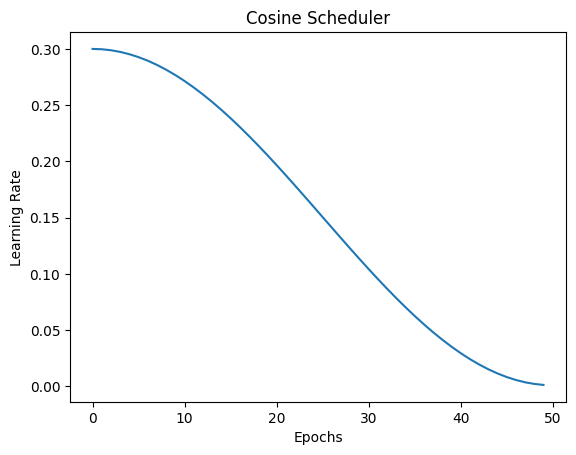

In [18]:
# credit: https://d2l.ai/chapter_optimization/lr-scheduler.html
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

scheduler = CosineScheduler(max_update=50, base_lr=0.3, final_lr=0.001)
num_epochs = 50
sch = [scheduler(t) for t in range(num_epochs)]
xtrain = np.arange(num_epochs)
plt.plot(xtrain, sch)
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.title("Cosine Scheduler")


## Model Definitions

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [20]:
class ZhZhAutoencoderTW(nn.Module):
    """
    Autoencoder to learn the weights connecting Chinese
    embeddings back to one-hot vectors. Initialize the
    weights connecting the embeddings and one-hot vectors
    with the transpose of the weights from the Tecent
    pretrained model, connecting the one-hot vector and
    embedding, to speed up training.
    """
    def __init__(self, pretrained, vocab):
        super(ZhZhAutoencoderTW, self).__init__()

        # Save the pretrained embedding within the model
        # load pretrained embeddings and freeze them
        self.weights    = torch.FloatTensor(pretrained.vectors)
        self.encoder    = nn.Embedding.from_pretrained(self.weights, freeze = True)

        # Make a copy of the pretrained weights and use them in the following layers
        copy_pretrained = copy.deepcopy(pretrained)
        self.copyweight = torch.FloatTensor(copy_pretrained.vectors)
        self.decoder    = nn.Parameter(self.copyweight.t())
        self.vocab      = vocab

    def forward(self, text):
        """The pipeline that takes input values through the network"""
        # Find the embeddings for text
        trained_embed = self.encoder(text)

        # Turn embedding back to one-hot
        one_hot       = trained_embed @ self.decoder

        return one_hot

In [21]:
# Autoencoder to learn the weights connecting embeddings back to one-hot vectors
class EnZhAutoencoderNonHidden(nn.Module):

    def __init__(self, pretrained_en, pretrained_zh, vocab_en, vocab_zh):
        super(EnZhAutoencoderNonHidden, self).__init__()

        # Save the pretrained English embedding from Tencent within the model
        # load pretrained embeddings and freeze them
        self.weights_en = torch.FloatTensor(pretrained_en.vectors)
        self.encoder    = nn.Embedding.from_pretrained(self.weights_en, freeze = True)

        # Load the pretrained weights from zhzhautoencoder
        # Use the pretrained weights to map Chinese embedding to one-hot
        # ***** use the tranpose!!!
        self.zh_weights = pretrained_zh
        self.decoder    = nn.Parameter(self.zh_weights, requires_grad=False)

        # Load the Chinese & English vocab
        self.vocab_en   = vocab_en
        self.vocab_zh   = vocab_zh

        # Weights for English to Chinese embeddings
        self.entozh = nn.Linear(100, 100)

    def forward(self, text):
        """The pipeline that takes input values through the network"""
        # Find the English embedding
        eng_emb = self.encoder(text)

        # Pass the English embedding through hidden layer
        # zh_emb  = self.hidden(eng_emb) # torch.Size([256, 100])

        # Find the corresponding index of Chinese word for
        # the English embedding decoder: torch.Size([100, 2000000])
        zh_emb = self.entozh(eng_emb)

        one_hot = zh_emb @ self.decoder

        return one_hot

In [22]:
def train(model, file, modelFilePath, num_epochs, optimizer, criterion):
    # Training
    avg_loss = []
    losses = 0
    start = time.time()
    print("Start Batch Size =", batch_size, file=open(file, 'a'))

    for epoch in range(num_epochs):
        losses = 0
        correct_test = 0
        total_test = 0
        accuracy_test = []
        for i, (en_index, zh_index) in enumerate(train_dataloader):
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Move inputs & outputs to cuda
            en_index = en_index.to(device)
            zh_index = zh_index.to(device)

            # Forward pass to get output/logits
            outputs_train = model(en_index)

            # Get predictions from the maximum value
            prob = TF.softmax(outputs_train, dim=1)
            # top_three = torch.topk(prob, 3, dim=1).indices
            # # print(top_three)
            index = torch.argmax(prob, dim=1)
            # print(index)


            # Total number of labels
            total_test += en_index.size(0)

            # Total correct predictions
            # correct = zh_index.tolist()
            # preds = top_three.tolist()

            # for i in range(len(preds)):
            #     if correct[i] in preds[i]:
            #         correct_test += 1

            correct_test += torch.sum(index==zh_index).item()

            # Calculate Loss: softmax --> cross entropy loss
            loss = criterion(outputs_train, zh_index)
            losses += loss.item()

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()

        print(correct_test)
        print(total_test)
        cur_accuracy = 100 * correct_test / total_test
        accuracy_test.append(cur_accuracy)
        print(f'Training accuracy at epoch {epoch}: %.15f' % (cur_accuracy))

        avg = losses / len(train_dataloader.dataset)
        avg_loss.append(avg)

        # Test the model every 10 epochs
        if epoch % 10 == 0 or epoch==49:
            test(model, file)
            model.train()
            torch.save(model.state_dict(), f"/content/drive/MyDrive/LING111 autoencoder/enzh_nonhidden {epoch}.pt")

        for param_group in optimizer.param_groups:
            param_group['lr'] = scheduler(epoch)
            print("Learning rate is now", param_group['lr'])

        print('%s (%d %d%%) %.15f' % (timeSince(start), epoch, epoch / num_epochs * 100, avg))
        torch.save(model.state_dict(), modelFilePath)

    print("Finish training!")
    return avg_loss

def test(model, file):
    correct_test = 0
    total_test = 0
    accuracy_test = []

    model.eval()
    with torch.no_grad():
        # Iterate through test dataset
        for i, (en_index, zh_index) in enumerate(test_dataloader):

            # Move inputs & outputs to cuda
            en_index = en_index.to(device)
            zh_index = zh_index.to(device)

            # Forward pass only to get logits/output
            outputs_test = model(en_index)

            # Get predictions from the maximum value
            prob = TF.softmax(outputs_test, dim=1)
            # top_three = torch.topk(prob, 3).indices
            index = torch.argmax(prob, dim=1)

            # print(top_three)
            # print(index)

            # correct = zh_index.tolist()
            # preds = top_three.tolist()

            # for i in range(len(preds)):
            #     if correct[i] in preds[i]:
            #         correct_test += 1

            # Total number of labels
            total_test += en_index.size(0)

            # Total correct predictions

            correct_test += torch.sum(index==zh_index).item()
        cur_accuracy = 100 * correct_test / total_test
        accuracy_test.append(cur_accuracy)
        # Print Loss
        print('Test accuracy: %.15f' % (cur_accuracy))

        return  accuracy_test

In [23]:
model_zhzh = ZhZhAutoencoderTW(wv_from_text_zh, vocab_zh).to(device)
model_zhzh_weight = torch.load('/content/drive/MyDrive/LING111 autoencoder/ling111_project_wt.pt', map_location='cuda:0')
model_zhzh.load_state_dict(model_zhzh_weight)

<All keys matched successfully>

In [24]:
# Extract the decoder weights to use in the final autoencoder
print("The weights in the ZhZhAutoencoderTW model are", model_zhzh.state_dict().keys())

The weights in the ZhZhAutoencoderTW model are odict_keys(['decoder', 'encoder.weight'])


In [25]:
model_enzh_decoder = model_zhzh.decoder.clone()
model_enzh = EnZhAutoencoderNonHidden(wv_from_text_en, model_enzh_decoder, vocab_en, vocab_zh).to(device)

In [26]:
print("The weights in the EnZhAutoencoder model are", model_enzh.state_dict().keys())

The weights in the EnZhAutoencoder model are odict_keys(['decoder', 'encoder.weight', 'entozh.weight', 'entozh.bias'])


In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_enzh.parameters(), lr=0.3)

In [28]:
train(model_enzh, '/content/drive/MyDrive/LING111 autoencoder/enzhautoencoder.txt', '/content/drive/MyDrive/LING111 autoencoder/enzh_nonhidden_weights.pt', 50, optimizer, criterion)

14
6188
Training accuracy at epoch 0: 0.226244343891403
Test accuracy: 0.634765625000000
Learning rate is now 0.3
0m 46s (0 0%) 28.978229752030771
28
6188
Training accuracy at epoch 1: 0.452488687782805
Learning rate is now 0.2997049959000266
1m 29s (1 2%) 17.513057124329599
39
6188
Training accuracy at epoch 2: 0.630252100840336
Learning rate is now 0.2988211478465144
1m 45s (2 4%) 17.476475977635644
39
6188
Training accuracy at epoch 3: 0.630252100840336
Learning rate is now 0.297351943983939
1m 58s (3 6%) 17.203536543448511
31
6188
Training accuracy at epoch 4: 0.500969618616677
Learning rate is now 0.29530318258873034
2m 12s (4 8%) 17.893707452933096
32
6188
Training accuracy at epoch 5: 0.517129928894635
Learning rate is now 0.2926829491861255
2m 31s (5 10%) 18.220393372568378
41
6188
Training accuracy at epoch 6: 0.662572721396251
Learning rate is now 0.2895015846402936
2m 51s (6 12%) 17.666137281046733
27
6188
Training accuracy at epoch 7: 0.436328377504848
Learning rate is now 

[28.97822975203077,
 17.5130571243296,
 17.476475977635644,
 17.20353654344851,
 17.893707452933096,
 18.220393372568378,
 17.666137281046733,
 17.669321327727303,
 17.657213483537948,
 17.359585052470507,
 17.011320443329076,
 16.776038832562772,
 16.675249549752294,
 16.288980061112486,
 15.768803582317844,
 15.597902501407715,
 15.247248367871789,
 14.18373479762999,
 14.267571319205267,
 13.60868587876106,
 12.905972027670744,
 12.618132361305399,
 12.016087004964245,
 11.508932911355648,
 11.007679540415927,
 10.339836944205267,
 9.83668262602517,
 9.06325798799087,
 8.709281512052687,
 7.8742964583670005,
 7.474114238637913,
 6.7202152974696485,
 6.180303424423405,
 5.715342614753984,
 5.28331154426915,
 4.682969520534326,
 4.2156406247238225,
 3.59694147880569,
 3.208565739716109,
 2.8071648339417647,
 2.384414396674385,
 2.0673084739877394,
 1.6964844479896826,
 1.3786941064737193,
 1.0733592742939648,
 0.843500343229051,
 0.6421284617033788,
 0.47581981703321163,
 0.3589046714

In [36]:
type(word_to_index_en["can"])

int

## Testing the performance of the model

In [48]:
# We want to test the model on different word groups
# This will let us investigate what kinds of senses the model prefers
# as well as how the model is performing in general across word classes

# Words that could be nouns but also verbs
nounverbs = ["walk", "fly", "bat", "spring", "can"]

# Concrete words
concrete = ["glass", "shirt", "house", "blood", "flower"]

# Emotion words
emotion = ["love", "hate", "happy", "confused", "angry"]

# Abstract words
abstract = ["democracy", "peace", "death", "fact", "being"]

nounverbs_en = []
for word in nounverbs:
    nounverbs_en.append(word_to_index_en[word])

nounverbs_en = torch.tensor(nounverbs_en).to(torch.int64)

concrete_en = []
for word in concrete:
    concrete_en.append(word_to_index_en[word])

concrete_en = torch.tensor(concrete_en).to(torch.int64)

emotion_en = []
for word in emotion:
    emotion_en.append(word_to_index_en[word])

emotion_en = torch.tensor(emotion_en).to(torch.int64)

abstract_en = []
for word in abstract:
    abstract_en.append(word_to_index_en[word])

abstract_en = torch.tensor(abstract_en).to(torch.int64)


# maybe different noun/verb classes, or conjunctions?

nounclass1 = ["dog", "cat", "bird", "snake", "cow"]
nounclass2 = ["fire", "water", "ice", "earth", "wind"]
verbclass1 = ["run", "jump", "swim", "speak", "talk"]
verbclass2 = ["be", "like", "have", "do", "exist"]
conjunctions = ["and", "but", "or", "not", "both"]


nounclass1_en = []
for word in nounclass1:
    nounclass1_en.append(word_to_index_en[word])

nounclass1_en = torch.tensor(nounclass1_en).to(torch.int64)

nounclass2_en = []
for word in nounclass2:
    nounclass2_en.append(word_to_index_en[word])

nounclass2_en = torch.tensor(nounclass2_en).to(torch.int64)

verbclass1_en = []
for word in verbclass1:
    verbclass1_en.append(word_to_index_en[word])

verbclass1_en = torch.tensor(verbclass1_en).to(torch.int64)
verbclass2_en = []
for word in verbclass2:
    verbclass2_en.append(word_to_index_en[word])

verbclass2_en = torch.tensor(verbclass2_en).to(torch.int64)
conjunctions_en = []
for word in conjunctions:
    conjunctions_en.append(word_to_index_en[word])

conjunctions_en = torch.tensor(conjunctions_en).to(torch.int64)


In [50]:
# Get model predictions for each of the groups

nounverbs_output = model_enzh(nounverbs_en.to(device))
concrete_output = model_enzh(concrete_en.to(device))
emotion_output = model_enzh(emotion_en.to(device))
abstract_output = model_enzh(abstract_en.to(device))
nounclass1_output = model_enzh(nounclass1_en.to(device))
nounclass2_output = model_enzh(nounclass2_en.to(device))
verbclass1_output = model_enzh(verbclass1_en.to(device))
verbclass2_output = model_enzh(verbclass2_en.to(device))
conjunctions_output = model_enzh(conjunctions_en.to(device))

In [51]:
# Get index from model predictions

nounverbs_index = torch.argmax(TF.softmax(nounverbs_output, dim=1), dim=1)
concrete_index = torch.argmax(TF.softmax(concrete_output, dim=1), dim=1)
emotion_index = torch.argmax(TF.softmax(emotion_output, dim=1), dim=1)
abstract_index = torch.argmax(TF.softmax(abstract_output, dim=1), dim=1)

nounclass1_index = torch.argmax(TF.softmax(nounclass1_output, dim=1), dim=1)
nounclass2_index = torch.argmax(TF.softmax(nounclass2_output, dim=1), dim=1)
verbclass1_index = torch.argmax(TF.softmax(verbclass1_output, dim=1), dim=1)
verbclass2_index = torch.argmax(TF.softmax(verbclass2_output, dim=1), dim=1)
conjunctions_index = torch.argmax(TF.softmax(conjunctions_output, dim=1), dim=1)

In [52]:
for i, j in zip(nounverbs_en.tolist(), nounverbs_index.tolist()):
    print(f"{vocab_en[i]} & {vocab_zh[j]}")

for i, j in zip(concrete_en.tolist(), concrete_index.tolist()):
    print(f"{vocab_en[i]} & {vocab_zh[j]}")

for i, j in zip(emotion_en.tolist(), emotion_index.tolist()):
    print(f"{vocab_en[i]} & {vocab_zh[j]}")

for i, j in zip(abstract_en.tolist(), abstract_index.tolist()):
    print(f"{vocab_en[i]} & {vocab_zh[j]}")

for i, j in zip(nounclass1_en.tolist(), nounclass1_index.tolist()):
    print(f"{vocab_en[i]} & {vocab_zh[j]}")

for i, j in zip(nounclass2_en.tolist(), nounclass2_index.tolist()):
    print(f"{vocab_en[i]} & {vocab_zh[j]}")

for i, j in zip(verbclass1_en.tolist(), verbclass1_index.tolist()):
    print(f"{vocab_en[i]} & {vocab_zh[j]}")

for i, j in zip(verbclass2_en.tolist(), verbclass2_index.tolist()):
    print(f"{vocab_en[i]} & {vocab_zh[j]}")

for i, j in zip(conjunctions_en.tolist(), conjunctions_index.tolist()):
    print(f"{vocab_en[i]} & {vocab_zh[j]}")


walk & 320路
fly & 进
bat & 糖稀
spring & 3
can & 需要
glass & 新生彩票
shirt & 衬衣
house & 修械所
blood & 血管
flower & 蝴蝶
love & 点开后
hate & 小幅收涨
happy & 目前的战绩
confused & 回信息
angry & 根本不认识
democracy & 独裁国家
peace & 门户
death & 封神榜2
fact & ·
being & 二十七名
dog & 战斗宠物
cat & 好带
bird & 鸟儿
snake & 捕兽夹
cow & 年总产值
fire & 小学三年级日记300字
water & ===
ice & ===
earth & 星球
wind & 经济发展方式
run & 进
jump & 哪段
swim & 高二日记二十篇
speak & 看到
talk & 500m
be & 2.68
like & 啊
have & 两年
do & 要说
exist & 搞错
and & 和
but & 啊
or & 只限于
not & 3000
both & 和
